# Transformations
> TBD (transforming vectors and graphics)

## Contents
TBD

## Intro

In this chapter, and leaning on the concepts we've learned in the previous chapters, we'll see how we can render any 2D or 3D figure by decomposing it into line segments and polygons defined by vectors.

Also, we'll introduce the concept of animation, which consists in render slightly different static images in quick sequence to *cheat* or mind and make it think that the image is continuously changing.

This changes in the images are powered by transformations. As a mental model, you can think of transformation as black boxes that receive an input and produce a geometric change on the given input (rotate, translate, scale,...).

We will discuss a broad class of vector transformations called *linear transformations* that, like rotations, transform vectors on a straight line to new vectors that also lie on a straight line. *Linear transformations* have numerous applications in math, physics and data analysis.

To visualize rotations, linear transformations and other relevant transformations, *OpenGL* will be used using *PyOpenGL* library. For animations we'll use *PyGame* a game development library for Python.

## Transforming 3D objects

The goal of this chapter is to learn how to create new 3D objexts from existing ones applying transformations.

Every transformation we look at will take a vector as an input and will return another vector:

```python
def transform(v):
    old_x, old_y, old_z = v
    # ... transform ...
    return (new_x, new_y, new_z)
```

### Drawing a Transformed Object

We'll use the *Utah teapot* as our 3D model reference. We will modify the vectors defining the teapot and re-render it, so that we can see the geometric effect of the transformation.

When we run it without changes we see:

In [6]:
from draw_teapot import draw_teapot

draw_teapot()

SystemExit: 0

As an example, we can define a function `scale2(vector)` that multiplies any input vector by `2.0` and returns the result:

In [7]:
from vectors import scale

def scale2(v):
    return scale(2.0, v)

Note that this function complies with the form given for the `transform(...)` function above, and therefore, it is a transformation.

Let's apply it to the teapot vectors and see what happens:

In [8]:
from teapot import load_triangles
from draw_model import draw_model

original_triangles = load_triangles()
scaled_triangles = [ 
    [scale2(vertex) for vertex in triangle] 
    for triangle in original_triangles
]

draw_model(scaled_triangles)

SystemExit: 0

Let's now apply another simple transformation: translation. We want to move every vertex of the 3D model one unit in the negative x direction, apply to the already scaled figure and see what happens:

In [9]:
from vectors import add

def translate_1_left(v):
    return add((-1, 0, 0), v)

translated_scaled_triangles = [
    [ translate_1_left(vertex) for vertex in triangle ]
    for triangle in scaled_triangles
]

draw_model(translated_scaled_triangles)

SystemExit: 0

### Composing vector transformations

Applying any number of transformations sequentially defines a new transformation. For example, we could package what we did in 2 steps in the previous section into a single transformation:

In [10]:
def scale2_then_translate1left(v):
    return translate_1_left(scale2(v))

original_triangles = load_triangles()
transformed_triangles = [
    [scale2_then_translate1left(vertex) for vertex in triangle]
    for triangle in original_triangles
]

draw_model(transformed_triangles)

SystemExit: 0

As vector transformations take vectors and return vectors, we can combine any number of them using *function composition*:

```python
def compose(f1, f2):
    def new_function(input):
        return f1(f2(input))
    return new_function
```

In [11]:
def compose(f1, f2):
    def new_function(input):
        return f1(f2(input))
    return new_function

scale2_then_translate1left = compose(translate_1_left, scale2)

original_triangles = load_triangles()
transformed_triangles = [
    [scale2_then_translate1left(vertex) for vertex in triangle]
    for triangle in original_triangles
]

draw_model(transformed_triangles)

SystemExit: 0

We've already seen that having to apply the *list comprehension* technique each time that we want to apply a transformation is kind of a nuisance.

We can improve that by creating a helper function `polygon_map(transformation, polygons)`:

In [12]:
def polygon_map(transformation, polygons):
    return [
        [transformation(vertex) for vertex in polygon]
        for polygon in polygons
    ]

draw_model(
    polygon_map(
        compose(translate_1_left, scale2), load_triangles()
        )
    )

SystemExit: 0

Both `compose(...)` and `polygon_map(...)` take vector transformations as arguments. 

Sometimes, it's also useful to have functions that return transformations. For example, we can define a `scale_by(scalar)` function:

In [16]:
def scale_by(scalar):
    def new_function(v):
        return scale(scalar, v)
    return new_function

draw_model(polygon_map(scale_by(0.5), load_triangles()))

SystemExit: 0

Similarly, we can use the same approach (having functions that return transformations) to define a `translate_by(...)` function:

In [13]:
def translate_by(translation_vector):
    def new_function(v):
        return add(translation_vector, v)
    return new_function

draw_model(polygon_map(translate_by((-1, 0, 0)), load_triangles()))

SystemExit: 0

As a result, we now have a very flexible, *functional* way of applying transformations thanks to *composition* and *functions that return functions*:

In [14]:
draw_model(polygon_map(compose(translate_by((-1, 0, 0)), scale_by(2)), load_triangles()))

NameError: name 'scale_by' is not defined

### Rotating an object about an axis

We already learn how to do rotations in 2D in the chapter [01 &mdash; Vectors in the 2D plane](../../01-vectors-in-the-2d-plane).
The technique consisted in converting the Cartesian coordinates of the vector to be rotated to its polar coordinates, applying the rotation, and then convert it back to its Cartesian coordinates.

This technique is also useful for 3D rotations because all 3D vector rotations are *isolated in planes*.

For example, considered the following situation in which we want to rotate a point in the 3D space around the z-axis:

![3D space rotations](../images/3d-space-rotations.png)



Note that when the point is rotated, the z coordinate of the point does not change &mdash; it is isolated on the z plane, and therefore, we could apply the 2D rotation technique to the x and y coordinates of the point.

Let's define the rotation function:

In [15]:
from vectors import to_polar, to_cartesian

def rotate2d(angle, vector):
    vector_length, vector_angle = to_polar(vector)
    vector_angle = vector_angle + angle
    return to_cartesian((vector_length, vector_angle))

And now the 3D rotation function to compute rotations about the z-axis:

In [16]:
def rotate_z(angle, vector):
    v_x, v_y, v_z = vector
    new_x, new_y = rotate2d(angle, (v_x, v_y))
    return (new_x, new_y, v_z)

And if we define a `rotate_z_by(...)` function that returns a function that performs the transformation, we will be able to start using it for our renders:

In [18]:
def rotate_z_by(angle):
    def new_function(v):
        return rotate_z(angle, v)
    return new_function

In [19]:
from math import pi

draw_model(polygon_map(rotate_z_by(pi / 4.0), load_triangles()))

SystemExit: 0

We can write similar functions to rotate about the x and y axis:

In [20]:
def rotate_x(angle, vector):
    x, y, z = vector
    new_y, new_z = rotate2d(angle, (y, z))
    return (x, new_y, new_z)

def rotate_x_by(angle):
    def new_function(v):
        return rotate_x(angle, v)
    return new_function


draw_model(polygon_map(rotate_x_by(pi / 2.), load_triangles()))

SystemExit: 0

In [21]:
def rotate_y(angle, vector):
    x, y, z = vector
    new_x, new_z = rotate2d(angle, (x, z))
    return (new_x, y, new_z)

def rotate_y_by(angle):
    def new_function(v):
        return rotate_y(angle, v)
    return new_function

draw_model(polygon_map(rotate_y_by(pi / 4.), load_triangles()))

SystemExit: 0

### Inventing your own geometric transformations

We've seen so far the more common *transformations*: scaling, translation and rotation. However, we can define additional ones as long as they conform with the requirement:
> a transformation takes as input a 3D vector and return a 3D vector.

For example, we can define a `stretch_x(...)` that returns a vector whose x coordinate has been stretched:

In [24]:
def stretch_x(v):
    x, y, z = v
    return (4. * x, y, z)

draw_model(polygon_map(stretch_x, load_triangles()))

SystemExit: 0

In [25]:
def stretch_y(v):
    x, y, z = v
    return (x, 4. * y, z)

draw_model(polygon_map(stretch_y, load_triangles()))

SystemExit: 0

In [26]:
def cube_stretch_z(v):
    x, y, z = v
    return (x, y, z * z * z)

draw_model(polygon_map(cube_stretch_z, load_triangles()))

SystemExit: 0

In [ ]:
def cube_stretch_y(v):
    x, y, z = v
    return (x, y * y * y, z)

draw_model(polygon_map(cube_stretch_y, load_triangles()))

In [ ]:
Additional transformatios are possible, like *slanting*:

In [28]:
def slant_xy(v):
    x, y, z = v
    return (x + y, y, z)

draw_model(polygon_map(slant_xy, load_triangles()))

SystemExit: 0

## Linear Transformations

Linear transformations are special transformations where vector arithmetics looks the same before and after the transformation. Linear transformations are one of the main objects of study in linear algebra.

### Preserving vector arithmetic

Let's try to understand what *linear transformations* mean with examples.

We've already seen that you can picture the sum of two vectors as the vector we arrive to when we apply the *tip-to-tail* rule, or as the vector from the origin to the tip of the parallelogram they define.

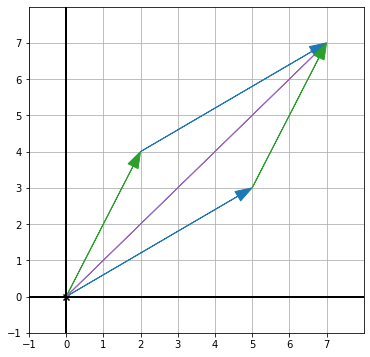

In [6]:
from draw2d import draw2d, Arrow2D, blue, green, purple
from vectors_my_implementation import add

u = (5, 3)
v = (2, 4)

draw2d(
    Arrow2D(u, color=blue),
    Arrow2D(v, color=green),
    Arrow2D(add(u, v), color=purple),
    Arrow2D(add(u, v), v, color=blue),
    Arrow2D(add(u, v), u, color=green)
)

Let's try a vector transformation &mdash; we will apply a counterclockwise rotation about the origin and call this transformation $ R $. We will apply this transformation to $ u $, $ v $ and $ u + v $:

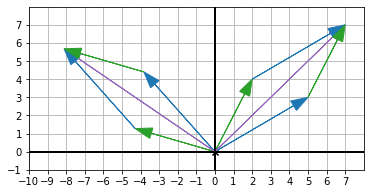

In [16]:
from draw2d import draw2d, Arrow2D, blue, green, purple
from vectors_my_implementation import add, rotate2d, to_radians

u = (5, 3)
v = (2, 4)
sum_vector = add(u, v) 

r_u, r_v, r_sum_vector = rotate2d(to_radians(100), [u, v, sum_vector])

draw2d(
    Arrow2D(u, color=blue),
    Arrow2D(v, color=green),
    Arrow2D(sum_vector, color=purple),
    Arrow2D(sum_vector, v, color=blue),
    Arrow2D(sum_vector, u, color=green),

    Arrow2D(r_u, color=blue),
    Arrow2D(r_v, color=green),
    Arrow2D(r_sum_vector, color=purple),
    Arrow2D(r_sum_vector, r_v, color=blue),
    Arrow2D(r_sum_vector, r_u, color=green),
)

From the picture we can see:

$
R(u) + R(v) = R(u + v)
$

For any three vectors $ u $, $ v $ and $ w $, where $ w = u + v $, if you apply the same transformation $ R $ to each of the three vectors, you find that $ R(u) + R(v) = R(w) $.

To describe this property, we say that rotations preserve vector sums.

Let's see if the same happens to scalar product and rotations:

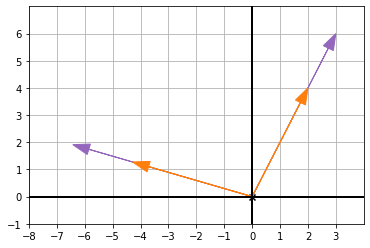

In [6]:
from draw2d import draw2d, Arrow2D, orange, purple
from vectors_my_implementation import scale, rotate2d, to_radians

v = (2, 4)
factor = 1.5
sv = scale(factor, v)

r_v, r_sv = rotate2d(to_radians(100), [v, sv])

draw2d(
    Arrow2D(sv, color=purple),
    Arrow2D(v, color=orange),
    Arrow2D(r_sv, color=purple),
    Arrow2D(r_v, color=orange)
)



Again, we see that for any vector $ v $, scalar $ s $, and rotation $ R $:

$
R( s \cdot \vec{v} ) = s \cdot R(\vec{v})
$

Rotations, or any other transformations that preserve vector sums and scalar multiples are called linear transformations:

> A linear transformation is a vector transformation $ T $ that preserves vector addition and scalar multiplication. That is, for any input vectors $ u $, $ v $, we have:

> $ T(u) + T(v) = T(u + v) $

> and for any pair of a scalar $ s $ and a vector $ v $, we have:

> $ T(s \cdot v) = s \cdot T(v) $

### Picturing linear transformations

Linear transformations are a very important topic. Thus it is important to recognize them properly and understand its concept.

Let's look into a transformation that is not a linear transformation, say $ S(v) $ that takes a vector $ v = (x, y) $ and outputs another vector whose Cartesian coordinates have been squared:

$
S(v) = (x², y²)
$

For $ S $ to be a linear transformation, it would have to verify:

$
S(u + v) = S(u) + S(v) \\
S(s \cdot v) = s \cdot S(v)
$

Let's picture it with an example:

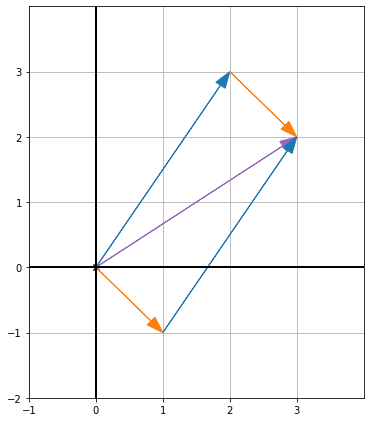

In [2]:
from draw2d import draw2d, Arrow2D, orange, purple, blue
from vectors_my_implementation import add, scale

u = (2, 3)
v = (1, -1)
sum_vector = add(u, v)

draw2d(
    Arrow2D(u, color=blue),
    Arrow2D(v, color=orange),
    Arrow2D(sum_vector, color=purple),
    Arrow2D(sum_vector, u, color=orange),
    Arrow2D(sum_vector, v, color=blue)
)


Now, let's apply the $ S $ transformation and see what happens:

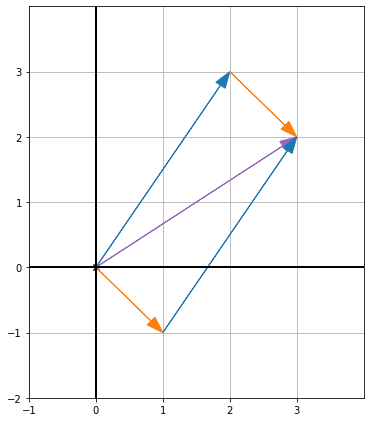

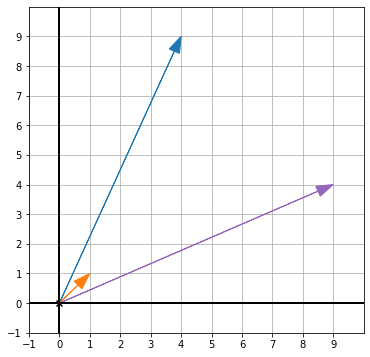

In [5]:
from draw2d import draw2d, Arrow2D, orange, purple, blue
from vectors_my_implementation import add, scale

u = (2, 3)
v = (1, -1)
sum_vector = add(u, v)

def s_transform(v):
    x, y = v
    return (x * x, y * y)

s_u = s_transform(u)
s_v = s_transform(v)
s_sum_vector = s_transform(sum_vector)    


draw2d(
    Arrow2D(u, color=blue),
    Arrow2D(v, color=orange),
    Arrow2D(sum_vector, color=purple),
    Arrow2D(sum_vector, u, color=orange),
    Arrow2D(sum_vector, v, color=blue)
    )

draw2d(
    Arrow2D(s_u, color=blue),
    Arrow2D(s_v, color=orange),
    Arrow2D(s_sum_vector, color=purple)
)

By looking at the picture, we clearly see that the purple vector does not represent the sum of the blue and orange vector. This can also be demonstrated algebraically. 

$
S(u + v) = S((u_x, u_y) + (v_x, v_y)) = S((u_x + v_x, u_y + v_y)) = ((u_x + v_x)², (u_y + v_y)²) \\

S(u) + S(v) = (u_x², u_y²) + (v_x², v_y²) = (u_x² + v_x², u_y² + v_y²)
$

and clearly:

$
((u_x + v_x)², (u_y + v_y)²) \ne (u_x² + v_x², u_y² + v_y²)
$

Let's try with another transformation $ D(v) $ that scales the input vector by a factor of 2:

$
D(u) = D((u_x, u_y)) = (2 \cdot u_x, 2 \cdot u_y)
$

Then, we have to see whether:

$
D(u + v) = D(u) + D(v) \\
D(s \cdot u) = s \cdot D(u)
$


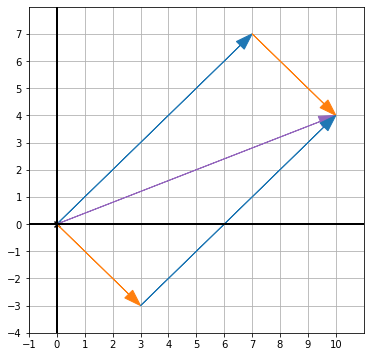

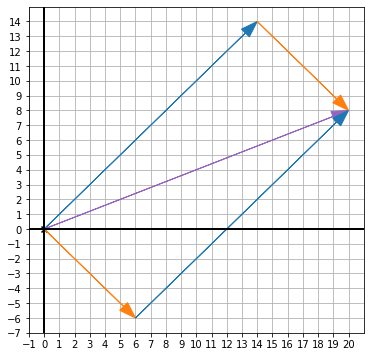

In [8]:
from draw2d import draw2d, Arrow2D, orange, purple, blue
from vectors_my_implementation import add, scale

u = (7, 7)
v = (3, -3)
sum_vector = add(u, v)


draw2d(
    Arrow2D(u, color=blue),
    Arrow2D(v, color=orange),
    Arrow2D(sum_vector, color=purple),
    Arrow2D(sum_vector, u, color=orange),
    Arrow2D(sum_vector, v, color=blue)
    )


def d_transform(v):
    x, y = v
    return (2 * x, 2 * y)

d_u = d_transform(u)
d_v = d_transform(v)
d_sum_vector = add(d_u, d_v)

draw2d(
    Arrow2D(d_u, color=blue),
    Arrow2D(d_v, color=orange),
    Arrow2D(d_sum_vector, color=purple),
    Arrow2D(d_sum_vector, d_u, color=orange),
    Arrow2D(d_sum_vector, d_v, color=blue)
    )


So, we see that $ D(u) + D(v) = D(u + v) $.

Let's now check the scalar product part:

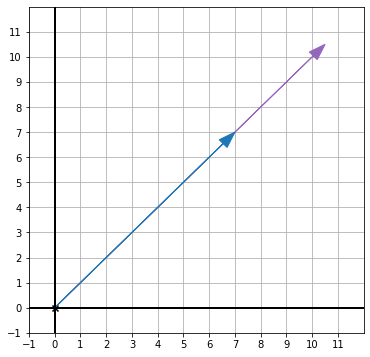

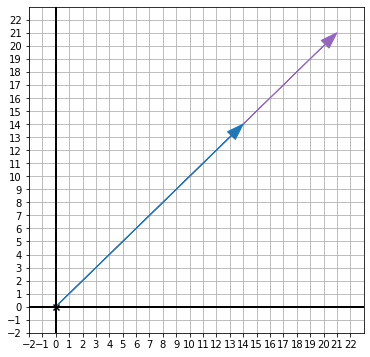

In [11]:
from draw2d import draw2d, Arrow2D, orange, purple, blue
from vectors_my_implementation import add, scale

u = (7, 7)
factor = 1.5
scalar_product = scale(factor, u)


draw2d(
    Arrow2D(scalar_product, color=purple),
    Arrow2D(u, color=blue)
    )


def d_transform(v):
    x, y = v
    return (2 * x, 2 * y)

d_u = d_transform(u)
d_scalar_product = scale(factor, d_u)

draw2d(
    Arrow2D(d_scalar_product, color=purple),
    Arrow2D(d_u, color=blue)
    )

So, the $ D $ transformation is a linear transformation as it preserves the vector sums and the scalar multiples.

Let's try now with translation. Say, we have a transformation $ B(u) $ that translates the vector $ u $ by a vector $ t $.

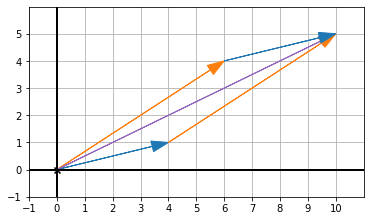

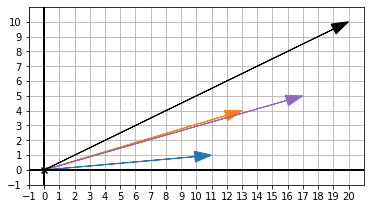

In [15]:
from draw2d import draw2d, Arrow2D, orange, purple, blue, black
from vectors_my_implementation import add, scale

u = (4, 1)
v = (6, 4)
sum_vector = add(u, v)


draw2d(
    Arrow2D(u, color=blue),
    Arrow2D(v, color=orange),
    Arrow2D(sum_vector, color=purple),
    Arrow2D(sum_vector, u, color=orange),
    Arrow2D(sum_vector, v, color=blue)
    )


def b_transform(v):
    t = (7, 0)
    return add(v, t)

b_u = b_transform(u)
b_v = b_transform(v)
b_sum_vector = b_transform(sum_vector)

draw2d(
    Arrow2D(b_u, color=blue),
    Arrow2D(b_v, color=orange),
    Arrow2D(b_sum_vector, color=purple),
    Arrow2D(add(d_u, d_v), color=black)
    )

Note how the translation is not a linear transformation, because $ B(u + v) \ne B(u) + B(v) $

| NOTE: |
| :---- |
| For a transformation to be linear, it must not move the origin. As the translation *moves the origin* of the input vector the transformation is not linear. |

Other examples of linear transformations are: reflection, projection, shearing, and any 3D analogy of those.

### Why linear transformations?

Because linear transformations preserve vector sums and scalar multiples, they also preserve a broader class of vector arithmetic operations.

In particular, the most general operation is called *linear combination*. A linear combination of a collection of vectors is a sum of scalar multiples of them.

For example, one linear combination of two vectors $ u $ and $ v $ would be $ 3 \cdot u - 2 \cdot v $, as it is the sum of scalar multiples of them.

As linear transformations preserves sums, scalar multiples they also preserve linear combinations. This fact let us restate the linear transformation properties in a much generic way for a transformation $ T $, a collection of vectors $ v_1, v_2, ... v_n $ and a collection of scalars $ s_1, s_2, ... s_n $, a linear transformation is such that:

$
T(s_1 \cdot v_1 + s_2 \cdot v_2 + ... + s_n \cdot v_n) = s_1 \cdot T(v_1) + s_2 \cdot T(v_2) + ... + s_n \cdot T(v_n)
$


One linear combination $ \frac{1}{2} \cdot u + \frac{1}{2} \cdot v $. As per the linear combination property:

$
\frac{1}{2} \cdot u + \frac{1}{2} \cdot v = \frac{1}{2} \cdot (u + v)
$

and therefore, that linear combination will give us the midpoint of the line segment connecting $ u $ and $ v $.

Let's picture that:

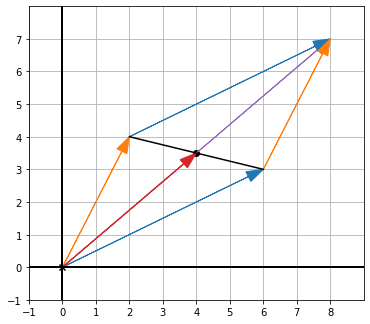

In [6]:
from draw2d import draw2d, Arrow2D, Segment2D, Points2D, orange, purple, blue, black, red
from vectors_my_implementation import add, scale

u = (6, 3)
v = (2, 4)

def t_transform(v):
    x, y = v
    return (0.5 * x, 0.5 * y)

t_u = t_transform(u)
t_v = t_transform(v)

linear_combo_result = add(t_u, t_v)

draw2d(
    Arrow2D(u, color=blue),
    Arrow2D(v, color=orange),
    Arrow2D(add(u, v), color=purple),
    Arrow2D(linear_combo_result, color=red),
    Points2D(linear_combo_result, color=black),
    Segment2D(u, v, color=black),
    Arrow2D(add(u, v), v, color=blue),
    Arrow2D(add(u, v), u, color=orange),    
    )




As linear transformations preserve linear combinatThis actually means that linear transformations send midpoints to midpoints. For example, a linear transformation that scales and rotates a vector, will send midpoints to midpoints.

It's less obvious but actually, the linear combination $ 0.25 \cdot u + 0.75 \cdot v $ gives us the a point which lies 75% on the way from $ u $ to $ v $.

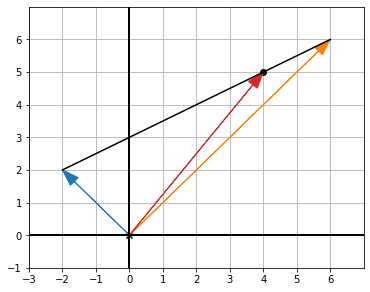

In [10]:
from draw2d import *
from vectors_my_implementation import *

u = (-2, 2)
v = (6, 6)
linear_combo_result = add(scale(0.25, u), scale(0.75, v))

draw2d(
    Arrow2D(u, color=blue),
    Arrow2D(v, color=orange),
    Arrow2D(linear_combo_result, color=red),
    Segment2D(u, v, color=black),
    Points2D(linear_combo_result, color=black)
    )

In fact, every point if the line segment between $ u $ and $ v $ is a "weighted average" of the sum of the vectors in the form:

$
s \cdot u + (1 - s) \cdot v
$

for some number $ s $ between 0 and 1.

We can use this fact to plot the line between two arbitrary given points $ P_1 $ and $ P_2 $:

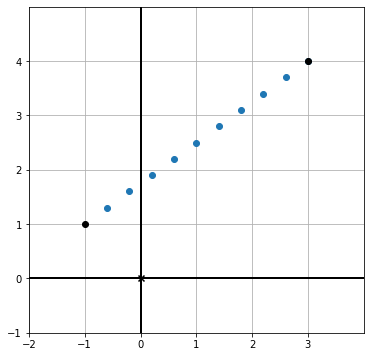

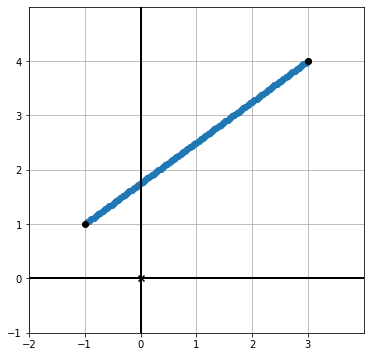

In [18]:
from draw2d import *
from vectors_my_implementation import *
import numpy as np

p1 = (-1, 1)
p2 = (3, 4)

def weighted_average(u, v):
    def new_function(s):
        return add(scale(s, u), scale(1. - s, v))
    return new_function

weighted_average_linear_combo = weighted_average(p1, p2)

weighted_averages = [weighted_average_linear_combo(s) for s in np.arange(0, 1, 0.1)]

# 10 points
draw2d(
    Points2D(*weighted_averages, color=blue),
    Points2D(p1, p2, color=black),
)

# 100 points
weighted_averages = [weighted_average_linear_combo(s) for s in np.arange(0, 1, 0.01)]

draw2d(
    Points2D(*weighted_averages, color=blue),
    Points2D(p1, p2, color=black),
)




One of the consequences of this fact, is that a linear transformation $ T $ will transform a weighted average of $ u $ and $ v $ to a weighted average of $ T(u) $ and $ T(v) $ as linear transformations preserve linear combinations.

In other words:
> a linear transformation $ T $ takes every point on the line segment connecting $ u $ and $ v $ to a point on the line segment connecting $ T(u) $ and $ T(v) $.

As our 3D models are made up of polygons, who are outlines by line segments, linear transformations will ensure that the structure of our models will be preserved.

Let's picture that with a triangle and a rotation tranformation.

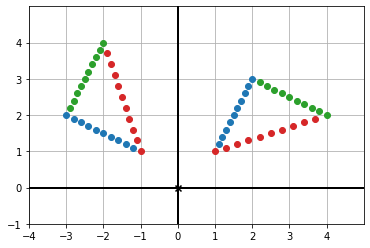

In [13]:
from draw2d import *
from vectors_my_implementation import *
import numpy as np

triangle = [(1, 1), (2, 3), (4, 2)]


# weighted averages outlining the segments
def weighted_average(u, v):
    def new_function(s):
        return add(scale(s, u), scale(1. - s, v))
    return new_function

edges = [
    [weighted_average(triangle[0], triangle[1])(s) for s in np.arange(0, 1, 0.1)],
    [weighted_average(triangle[1], triangle[2])(s) for s in np.arange(0, 1, 0.1)],
    [weighted_average(triangle[2], triangle[0])(s) for s in np.arange(0, 1, 0.1)],
    ]

def getColorForEdge(i):
    if i == 0:
        return blue
    elif i == 1:
        return green
    else:
        return red

def getPoints(edges):
    points = []
    for i in range(0, len(edges)):
        points.append(Points2D(*edges[i], color=getColorForEdge(i)))
    return points


rotated_edges = [
    [ rotate2d(to_radians(90), point) for point in edges[i] ]
    for i in range(0, len(edges))
]

# Now we rotate applying the transformation to all the points
# We know that rotation is a linear transformation, and therefore,
# the *shape structure* should be preserved

draw2d(
    *getPoints(edges), 
    *getPoints(rotated_edges)
    )


By contrast, if we apply a nonlinear transformation, the shape will get distorted. Let's see that with a simple example in which we apply the transformation $ S(v) = (v_x², v_y²) $

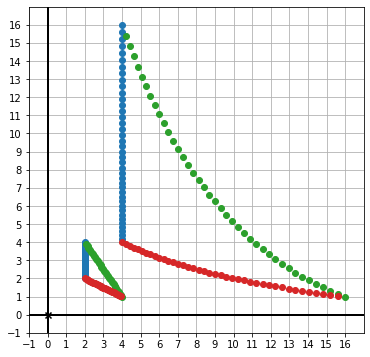

In [21]:
from draw2d import *
from vectors_my_implementation import *
import numpy as np

triangle = [(2, 2), (2, 4), (4, 1)]


# weighted averages outlining the segments
def weighted_average(u, v):
    def new_function(s):
        return add(scale(s, u), scale(1. - s, v))
    return new_function

edges = [
    [weighted_average(triangle[0], triangle[1])(s) for s in np.arange(0, 1, 0.025)],
    [weighted_average(triangle[1], triangle[2])(s) for s in np.arange(0, 1, 0.025)],
    [weighted_average(triangle[2], triangle[0])(s) for s in np.arange(0, 1, 0.025)],
    ]

def getColorForEdge(i):
    if i == 0:
        return blue
    elif i == 1:
        return green
    else:
        return red

def getPoints(edges):
    points = []
    for i in range(0, len(edges)):
        points.append(Points2D(*edges[i], color=getColorForEdge(i)))
    return points


def s_transformation(v):
    x, y = v
    return (x * x, y * y)

rotated_edges = [
    [ s_transformation(point) for point in edges[i] ]
    for i in range(0, len(edges))
]

draw2d(
    *getPoints(edges), 
    *getPoints(rotated_edges)
    )

Note how applying the $ S $ transformation does not preserve the *straightness* of the edges of the triangle.

As a summary:
+ linear transformations respect the algebraic properties of vectors, preserving sums, scalar multiples, and linear combinations.
+ linear transformations also respect the geometric properties of collections of vectors, sending line segments and polygons defined by vectors to new ones defined by the transformed vectors.

### Computing linear transformations

We know from previous chapters how to break 2D and 3D vectors into their components.
For example:

$
v = (4, 3, 5) = (4, 0, 0) + (0, 3, 0) + (0, 0, 5)
$

Now, in the light of linear combinations, we can see that this decomposition can be expressed in terms of a linear combination:

$
v = (4, 3, 5) = 4 \cdot (1, 0, 0) + 3 \cdot (0, 1, 0) + 5 \cdot (0, 0, 1)
$

This trivial fact has very profound consequences:
> any 3D vector can be decomposed into a linear combination of three vectors $ (1, 0, 0) $, $ (0, 1, 0) $, and $ (0, 0, 1) $. The scalars appearing in this decompositions for a vector $ v $ are exactly the coordinates of $ v $.

Also, the tree vectors $ (1, 0, 0) $, $ (0, 1, 0) $, and $ (0, 0, 1) $ are called the *standard basis* for the three-dimensional space, and are commonly denoted as $ e1 $, $ e2 $ and $ e3 $ (or sometimes $ i $, $ j $ and $ k $).

When working in the 2D plane $ e1 = (1, 0) $ and $ e2 = (0, 1) $ are the standard basis for the two-dimensional plane.


This change in perspective in which we see a vector in the 2D plane or 3D space as a linear combination, makes it easy to compute linear transformations.

Because linear transformations preserve linear combinations, when computing a linear transformations we can restrict ourselves to compute how it affects the standard basis vectors.

Let's demonstrate this algebraically:

Let $ T $ be a linear transformation:

$
T(w) = T(x \cdot e1 + y \cdot e2) = x \cdot T(e1) + y \cdot T(e2)
$

Thus, as any vector can be expressed as a linear combination of the standard basis, and as linear transformations preserve linear combinations so that $ T(a \cdot u + b \cdot v) = a\cdot T(u) + b \cdot T(v) $ the transformation of any given vector $ w $ ends up being a linear combination of the transformation applied to $ e1 $ and $ e2 $.

Let's apply this to a 3D example.

Let $ A $ be a linear transformtion. All we know about it is:
$
A(e1) = (1, 1, 1) \\
A(e2) = (1, 0, -1) \\
A(e3) = (0, 1, 1)
$

If $ v = (-1, 2, 2) $, what is $ A(v) $ ?

The solution is easy:

$
A(v) = A((-1, 2, 2)) = A(-e1 + 2 \cdot e2 + 2 \cdot e3)
$

In virtue of A being a linear transformation, it will preserve linear combinations and therefore:

$
A(-e1 + 2 \cdot e2 + 2 \cdot e3) = -1 \cdot A(e1) + 2 \cdot A(e2) + 3 \cdot A(e3) \\
= -1 \cdot (1, 1, 1) + 2 \cdot (1, 0, -1) + 2 \cdot (0, 1, 1) \\
= (-1 + 2 + 0, -1 + 0 + 2, -1 - 2 + 2) \\
= (1, 1, -1)
$

We can also apply this linear transformation to the Utah teapot:

In [25]:
from teapot import load_triangles
from draw_model_custom_impl import draw_model_anim
from transformations_support import *
from vectors_my_implementation import *

A_e1 = (1, 1, 1)
A_e2 = (1, 0, -1)
A_e3 = (0, 1, 1)

def a_transformation(v):
    x, y, z = v
    return add(
        scale(x, A_e1),
        scale(y, A_e2),
        scale(z, A_e3)
    )


draw_model_anim(polygon_map(a_transformation, load_triangles()))


SystemExit: 0

As a summary:
+ a 2D linear transformation $ T $ is defined completely by the values of $ T(e1) $ and $ T(e2) $.
+ a 3D linear transformation $ T $ is defined completely by the values of $ T(e1) $, $ T(e2) $ and $ T(e3) $.

This reduces the complexity of applying linear transformations, as any 2D linear transformation would be defined by 4 numbers (2 vectors of dimension 2) and any 3D linear transformation would be completely defined by 9 numbers (3 vectors of 3 dimensions).

As a consequence, the behavior of linear transformations would be defined by lists of vectors, aka matrices.
